In [558]:
import pandas as pd
import math
import pickle
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras_tuner import BayesianOptimization
plt.style.use('fivethirtyeight')

# Forecasting

We would like you to take what you have discovered in EDA and develop a model
for forecasting future close returns. In addition to close returns and High/Low
ratios, you can use your imagination and any feature engineering techniques you
know to create more features to use in your model.

You will also need to think about how to evaluate the performance of your
model. 

Given what you know about the distribution of the data, what metrics
may be appropriate? 

Can you turn your model predictions into a simple trading
strategy?

Please try and motivate any modelling decisions you make. Why have you chosen that particular model? How have you dealt with over-fitting? 

Are there any
hyper-parameters that you have tuned?


In [311]:
open_file = open("open_sublist.pkl",'rb')
open_df = pickle.load(open_file)

high_file = open("high_sublist.pkl",'rb')
high_df = pickle.load(high_file)

low_file = open("low_sublist.pkl",'rb')
low_df = pickle.load(low_file)

close_file = open("low_sublist.pkl",'rb')## Step 1
close_df = pickle.load(close_file)

volume_file = open("volume_sublist.pkl",'rb')
volume_df = pickle.load(volume_file)

future_return1_file = open("future_return1_sublist.pkl",'rb')
future_return1_df = pickle.load(future_return1_file)

close_return_file = open("close_return_sublist.pkl",'rb')
close_return_df = pickle.load(close_return_file)

high_low_file = open("high_low_sublist.pkl",'rb')
high_low_df = pickle.load(high_low_file)

volume_change_lag1_file = open("volume_change_lag1.pkl",'rb')
volume_change_lag1_df = pickle.load(volume_change_lag1_file)

In [312]:
open_df

,1PG,3PL,AAA,AAC,AAD,AAX,ABC,ABP,ABX,ACR,...,ORL,PIO,PMP,QOZ,QRX,SIQ,TLG,UBI,ACO,ELD
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.195,2.290,50.10,1.455,2.950,0.430,3.61,3.00,0.300,1.285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,1.230,2.220,50.11,1.470,2.870,0.430,3.63,3.05,0.300,1.325,...,3.85,0.014,0.430,12.42,0.022,1.465,0.240,0.170,NaN,NaN
2015-01-06,1.260,2.060,50.11,1.472,2.740,0.427,3.60,3.06,0.290,1.300,...,3.85,0.015,0.430,12.29,0.026,1.445,0.235,0.170,1.34,2.48
2015-01-07,1.245,2.050,50.10,1.480,2.700,0.425,3.58,3.09,0.290,1.325,...,3.85,0.017,0.420,12.05,0.026,1.430,0.270,0.175,1.27,2.46
2015-01-08,1.250,2.100,50.13,1.500,2.640,0.425,3.62,3.11,0.285,1.315,...,3.75,0.018,0.420,12.26,0.025,1.440,0.280,0.175,1.31,2.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,NaN,1.290,50.14,1.255,1.960,NaN,6.91,3.95,0.100,0.155,...,NaN,0.021,0.250,13.96,NaN,11.880,0.680,0.230,NaN,8.82
2018-06-26,NaN,1.250,50.14,1.235,1.960,NaN,6.92,3.86,0.100,0.155,...,NaN,0.021,0.235,13.82,NaN,11.900,0.680,0.235,NaN,8.80
2018-06-27,NaN,1.245,50.15,1.220,1.955,NaN,6.93,3.86,0.100,0.150,...,NaN,0.020,0.230,13.91,NaN,11.660,0.680,0.235,NaN,8.56


We now create a forecasting model with a random stock. Here we will choose AAD.

In [1092]:
df = pd.DataFrame()
df['open'] = open_df[['AAD']]
df['high'] = high_df[['AAD']]
df['low'] = low_df[['AAD']]
df['close'] = close_df[['AAD']]
df['volume'] = volume_df[['AAD']]
df['Close Return'] = close_return_df[['AAD']]
df['HighLow'] = high_low_df[['AAD']]
df['VolumeChangeLag1'] = volume_change_lag1_df[['AAD']]
df['FutureReturn1'] = future_return1_df[['AAD']]

In [1093]:
df.head()

,open,high,low,close,volume,Close Return,HighLow,VolumeChangeLag1,FutureReturn1
Date,,,,,,,,,
2015-01-02,2.95,2.95,2.870,2.870,303624,-0.016949,1.027875,NaN,NaN
2015-01-05,2.87,2.92,2.790,2.790,1535349,-0.017422,1.046595,NaN,-0.027586
2015-01-06,2.74,2.77,2.680,2.680,2800376,-0.014599,1.033582,4.056745,-0.042553
2015-01-07,2.70,2.73,2.520,2.520,5436637,-0.040741,1.083333,0.823934,-0.040741
2015-01-08,2.64,2.67,2.635,2.635,2801524,0.003788,1.013283,0.941395,0.023166


In [1094]:
df.shape

(883, 9)

We would like to drop the first two rows as it contains missing values due to lag in some features.

In [1095]:
df = df.dropna()

In [1096]:
df.describe()

,open,high,low,close,volume,Close Return,HighLow,VolumeChangeLag1,FutureReturn1
count,881.000000,881.000000,881.000000,881.000000,8.810000e+02,881.000000,881.000000,881.000000,881.000000
mean,2.150028,2.181902,2.117017,2.117017,2.120646e+06,0.000282,1.030615,0.281885,-0.000092
std,0.285960,0.292291,0.278682,0.278682,2.387220e+06,0.022143,0.023381,1.501289,0.024664
min,1.545000,1.595000,1.515000,1.515000,2.123410e+05,-0.221198,1.007634,-0.897525,-0.217593
25%,1.955000,1.982000,1.935000,1.935000,1.070171e+06,-0.009569,1.018433,-0.349538,-0.009901
50%,2.100000,2.130000,2.070000,2.070000,1.542055e+06,0.000000,1.025735,-0.025447,0.000000
75%,2.280000,2.310000,2.240000,2.240000,2.302198e+06,0.009950,1.035185,0.415667,0.010050
max,2.860000,2.970000,2.800000,2.800000,4.166394e+07,0.122857,1.335385,28.719454,0.140000


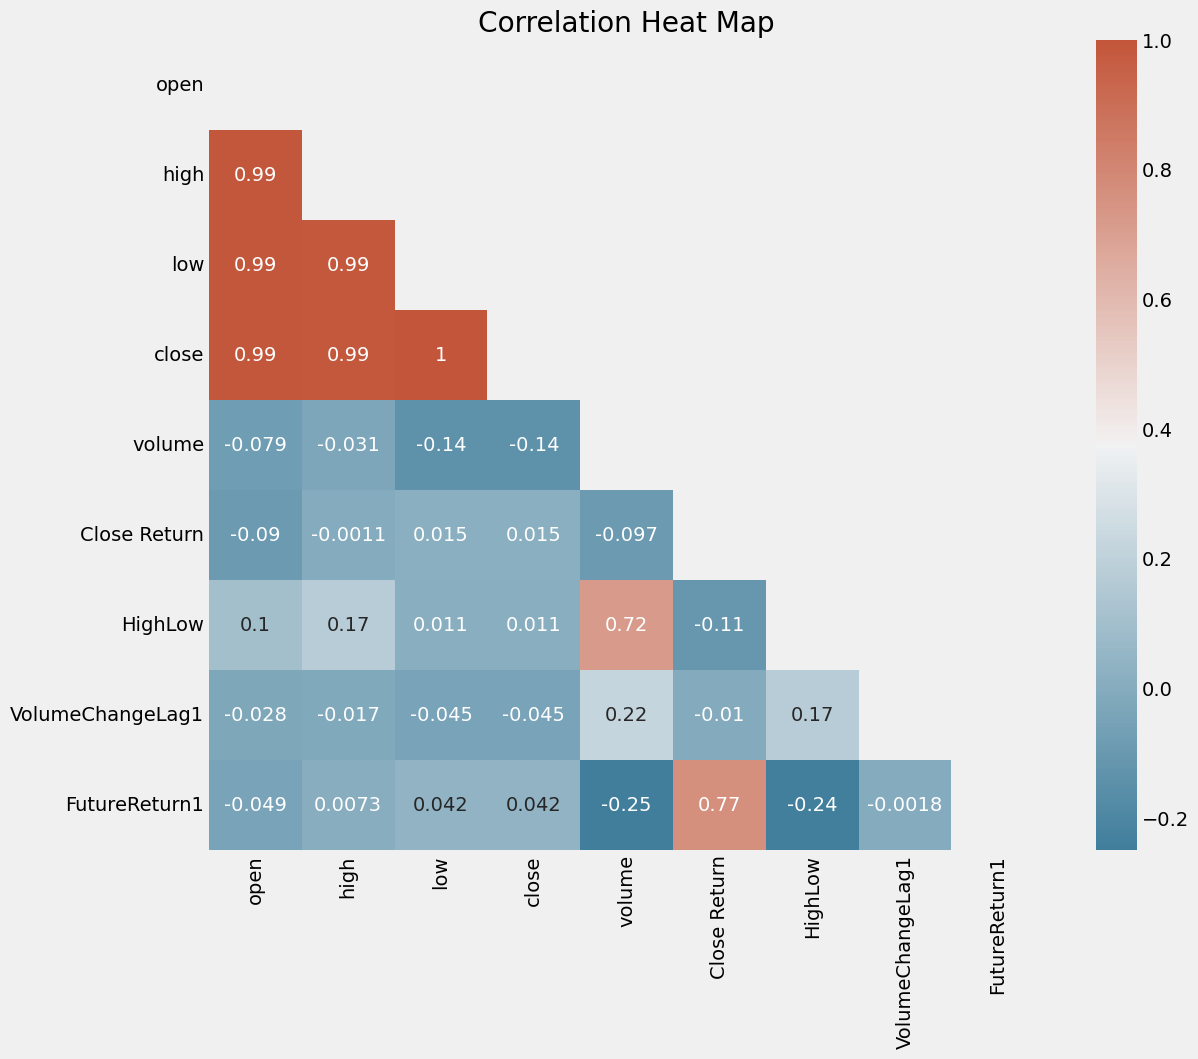

In [1098]:
# Correlation between different variables
#
corr = df.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))

plt.title("Correlation Heat Map")
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.savefig('Corr Heatmap.png')
plt.show()

We will use the close price for our model as close prices have taken account all the historical events that happened such as dividends, news, shareholder meetings, and etc.

Since we want to predict the next day price to find the future return, we will pay attention to the features that are correlated to the Close price. Since volumeChangeLag1 and FutureReturn1 has a high correlation to Close price, we will keep those two features for our model.

In [1050]:
df

,open,high,low,close,volume,Close Return,HighLow,VolumeChangeLag1,FutureReturn1
Date,,,,,,,,,
2015-01-06,2.740,2.770,2.680,2.680,2800376,-0.014599,1.033582,4.056745,-0.042553
2015-01-07,2.700,2.730,2.520,2.520,5436637,-0.040741,1.083333,0.823934,-0.040741
2015-01-08,2.640,2.670,2.635,2.635,2801524,0.003788,1.013283,0.941395,0.023166
2015-01-09,2.690,2.740,2.670,2.670,1599281,0.014870,1.026217,-0.484695,0.030189
2015-01-12,2.710,2.740,2.700,2.700,902243,0.007380,1.014815,-0.429139,0.000000
...,...,...,...,...,...,...,...,...,...
2018-06-25,1.960,2.010,1.960,1.960,1760358,0.012755,1.025510,-0.087618,-0.017327
2018-06-26,1.960,1.985,1.950,1.950,1549875,0.002551,1.017949,-0.321212,-0.010076
2018-06-27,1.955,2.000,1.955,1.955,997894,0.007673,1.023018,-0.119568,0.002545


In [1051]:
df['EMA'] = TA.EMA(df, 15)
df = pd.concat([df, TA.BBANDS(df, 15)], axis=1, join="inner")

In [1052]:
df = df.filter(items=['close', 'VolumeChangeLag1', 'FutureReturn1', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER'])

In [1053]:
df = df.dropna()

We are now left with these 5 features for our next step.

In [1089]:
plt.figure(figsize=(16,8))
plt.title('AAD Close Price History')
plt.plot(df[['close']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD($)', fontsize=18)
plt.savefig('AAD Close Price History.png')

<Figure size 640x480 with 0 Axes>

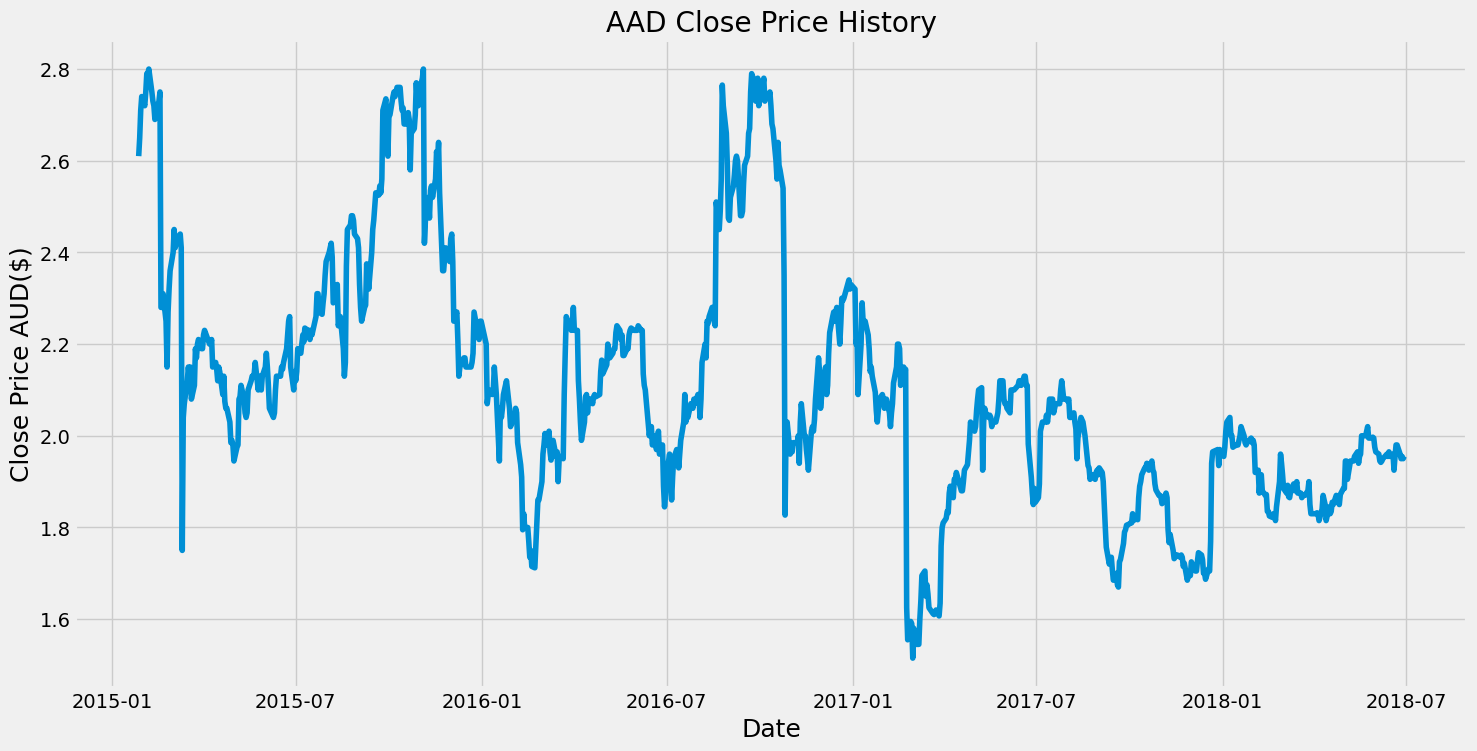

In [1090]:
plt.show()

## LSTM

In [1055]:
data = df.to_numpy()

In [1056]:
train_len = math.ceil(0.7*len(scaled_data))
train_data = data[0:train_len, :]
test_data = data[train_len:, :]

In [1057]:
test_data.shape

(250, 6)

In [1058]:
normaliser = MinMaxScaler()
train_normalised_data = normaliser.fit_transform(train_data)
test_normalised_data = normaliser.transform(test_data)

Use the last 21 days historical data to predict the next coming day as it is the average trading days in a month.

In [1059]:
#create train dataset

history_points = 21
X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
y_test = np.array([test_normalised_data[:,0][i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])

In [1060]:
X_train.shape

(596, 21, 6)

In [1061]:
y_train.shape

(596,)

In [1062]:
X_test.shape

(229, 21, 6)

In [1063]:
y_test.shape

(229,)

### First Try on Modeling With LSTM

In [1064]:
#Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [1065]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [1066]:
#Train Model
history = model.fit(X_train, y_train, batch_size=1, epochs=10, validation_split = 0.1)

Epoch 1/10
536/536 [==============================] - 7s 10ms/step - loss: 0.0174 - val_loss: 0.0046
Epoch 2/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0086 - val_loss: 0.0022
Epoch 3/10
536/536 [==============================] - 5s 10ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 4/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 5/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 6/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0033 - val_loss: 7.7771e-04
Epoch 7/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 8/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0038 - val_loss: 9.5613e-04
Epoch 9/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 10/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0037 - val_lo

In [1067]:
forecasts = model.predict(X_test)

In [1068]:
forecasts.shape

(229, 1)

In [1069]:
test_normalised_data[21:, 1:].shape

(229, 5)

In [1070]:
# invert scaling for forecast

forecasts = np.concatenate((forecasts, test_normalised_data[21:, 1:]), axis=1)
forecasts = normaliser.inverse_transform(forecasts)
forecasts = forecasts[:,0]

In [1071]:
rmse = np.sqrt(np.mean(forecasts-y_test)**2)
rmse

1.58690972451521

In [1072]:
#Data for Plotting
train = df[:train_len+21][['close']]
valid = df[train_len+21:][['close']]
valid['forecasts'] = forecasts

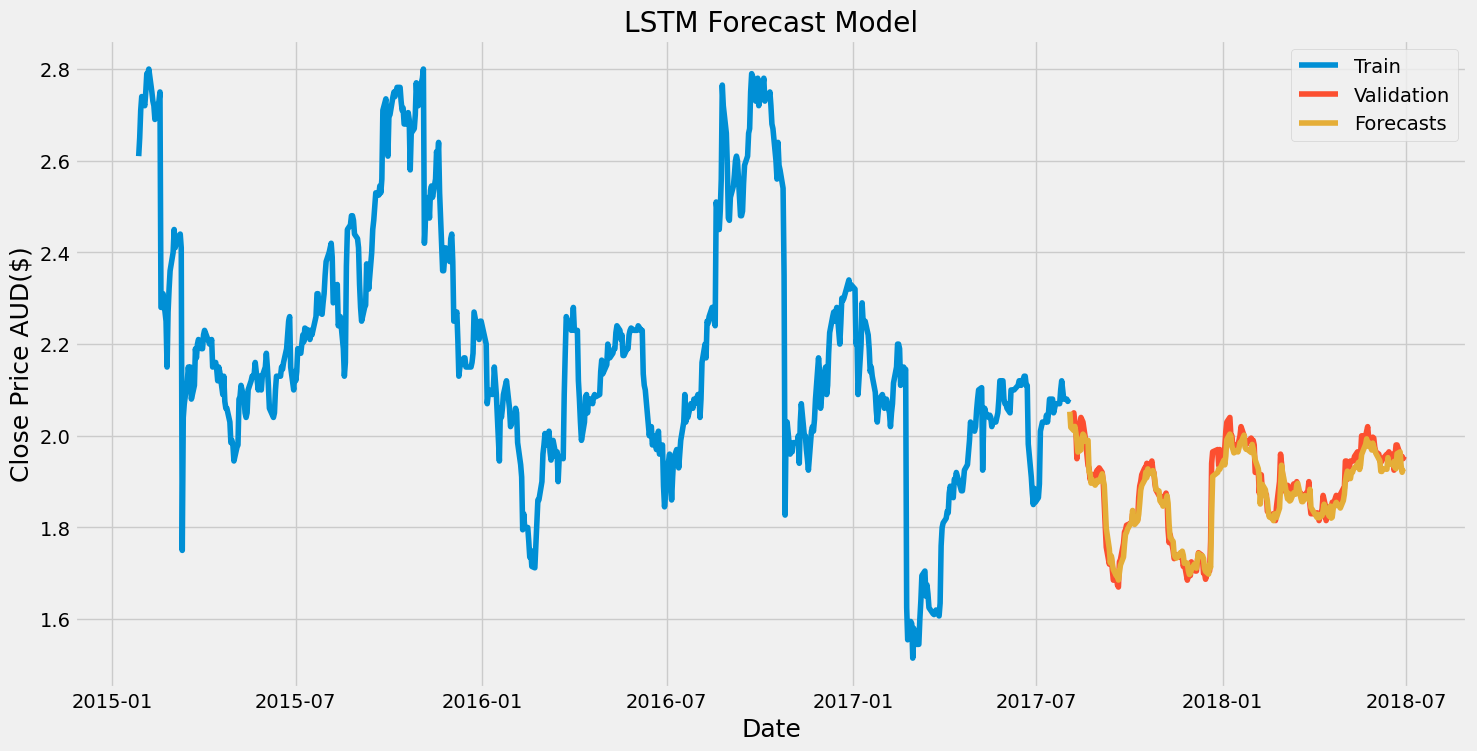

In [1073]:
#Plot Data
plt.figure(figsize=(16,8))
plt.title('LSTM Forecast Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'forecasts']])
plt.legend(['Train', 'Validation', 'Forecasts'], loc='upper right')
plt.show()

In [1074]:
valid

,close,forecasts
Date,,
2017-08-03,2.040,2.052483
2017-08-04,2.040,2.018463
2017-08-07,2.050,2.011336
2017-08-08,2.030,2.020479
2017-08-09,2.015,2.006317
...,...,...
2018-06-25,1.960,1.964841
2018-06-26,1.950,1.935340
2018-06-27,1.955,1.920388


In [1075]:
difference_df = valid.copy()

#pct forecasted return
difference_df['forecasts'] = difference_df['forecasts'].shift(-1)
difference_df['forecast_pct'] = (difference_df['forecasts']/difference_df['close']) - 1
difference_df['forecasts'] = difference_df['forecasts'].shift(1)
difference_df['forecast_pct'] = difference_df['forecast_pct'].shift(1)

#find the actual pct return
difference_df['close_pct'] = difference_df['close'].pct_change(1)

#difference in forecast and actual return
difference_df['abs_pct_diff'] = abs(difference_df['close_pct'] - difference_df['forecast_pct'])

In [1076]:
difference_df.describe()

,close,forecasts,forecast_pct,close_pct,abs_pct_diff
count,229.000000,228.000000,228.000000,228.000000,228.000000
mean,1.882332,1.871983,-0.005063,-0.000098,0.010033
std,0.096625,0.087148,0.007202,0.013442,0.008386
min,1.670000,1.685254,-0.022780,-0.037534,0.000172
25%,1.825000,1.822261,-0.009839,-0.006888,0.004137
50%,1.895000,1.883129,-0.005761,0.000000,0.008102
75%,1.955000,1.935892,-0.001206,0.005260,0.013889
max,2.050000,2.020479,0.032462,0.096045,0.063583


## Hyperparameter Tuning 

Grid Search to tune hyperparameters

In [1077]:
#Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [1078]:
n_input = 6
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units',min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(LSTM(hp.Int('units',min_value=32, max_value=128, step=32), return_sequences=False))
    
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32)))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer='adam')

    return model

In [1079]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1)

bayesian_opt_tuner.search(X_train, y_train,epochs=10,
     validation_data=(X_test, y_test),
     validation_split=0.1,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [1080]:
bayesian_opt_tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 96
Score: 0.006944040302187204
Trial summary
Hyperparameters:
units: 64
Score: 0.00782271008938551
Trial summary
Hyperparameters:
units: 32
Score: 0.008758308365941048


In [1081]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 96)            39552     
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dense (Dense)                (None, 96)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 123,073
Trainable params: 123,073
Non-trainable params: 0
_________________________________________________________________


In [1082]:
forecasts = model.predict(X_test)

In [1083]:
# invert scaling for forecast
forecasts = np.concatenate((forecasts, test_normalised_data[21:, 1:]), axis=1)
forecasts = normaliser.inverse_transform(forecasts)
forecasts = forecasts[:,0]

In [1084]:
rmse = np.sqrt(np.mean(forecasts-y_test)**2)
rmse

1.630672999022701

In [1085]:
#Data for Plotting
train = df[:train_len+21][['close']]
valid = df[train_len+21:][['close']]
valid['forecasts'] = forecasts

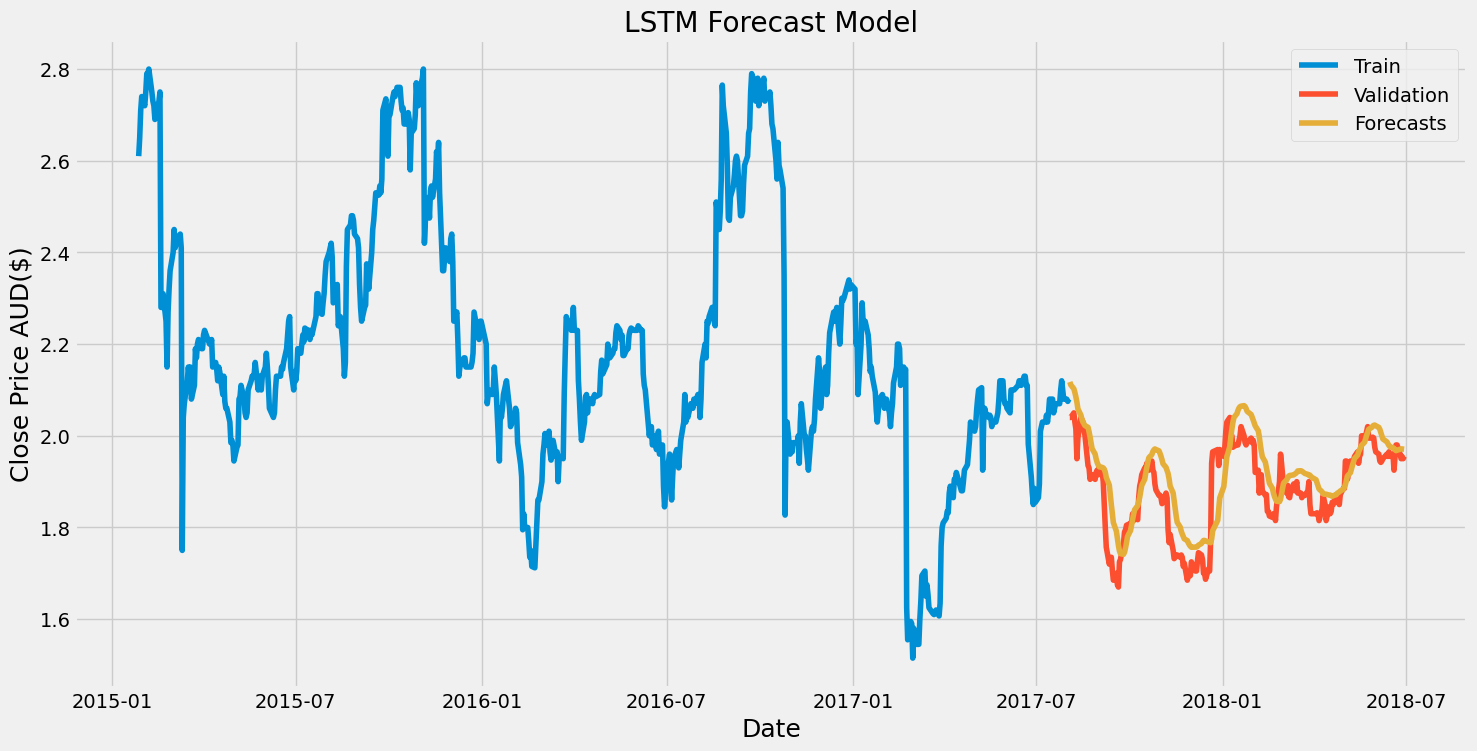

In [1086]:
#Plot Data
plt.figure(figsize=(16,8))
plt.title('LSTM Forecast Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'forecasts']])
plt.legend(['Train', 'Validation', 'Forecasts'], loc='upper right')
plt.show()

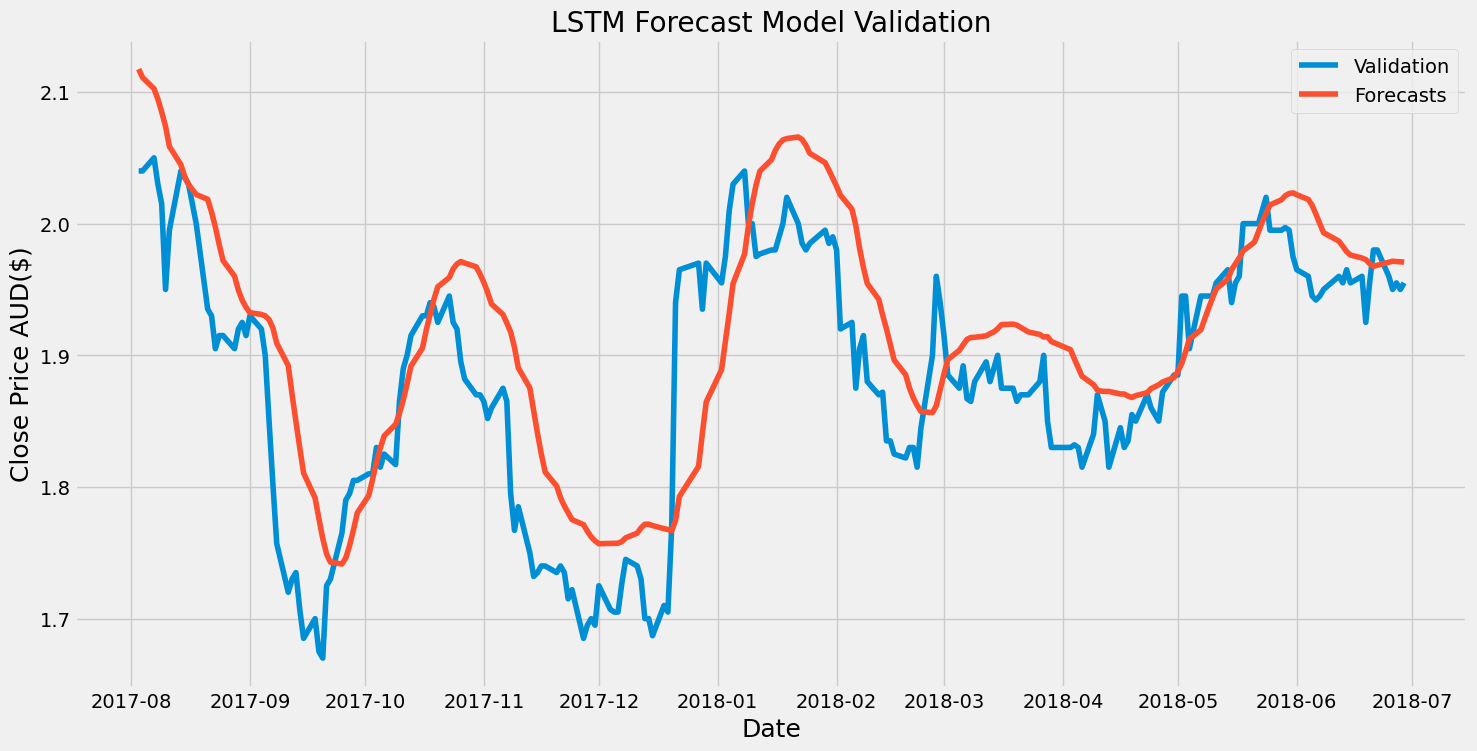

In [1087]:
#Plot Data
plt.figure(figsize=(16,8))
plt.title('LSTM Forecast Model Validation')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD($)', fontsize=18)
plt.plot(valid[['close', 'forecasts']])
plt.legend(['Validation', 'Forecasts'], loc='upper right')
plt.show()

In [1002]:
valid

,close,forecasts
Date,,
2017-08-03,2.040,2.117411
2017-08-04,2.040,2.110993
2017-08-07,2.050,2.102513
2017-08-08,2.030,2.094551
2017-08-09,2.015,2.084842
...,...,...
2018-06-25,1.960,1.970744
2018-06-26,1.950,1.971461
2018-06-27,1.955,1.971158


We now need to find the difference in forecasted future returns with actual returns

In [1003]:
difference_df = valid.copy()

#pct forecasted return
difference_df['forecasts'] = difference_df['forecasts'].shift(-1)
difference_df['forecast_pct'] = (difference_df['forecasts']/difference_df['close']) - 1
difference_df['forecasts'] = difference_df['forecasts'].shift(1)
difference_df['forecast_pct'] = difference_df['forecast_pct'].shift(1)

#find the actual pct return
difference_df['close_pct'] = difference_df['close'].pct_change(1)

#difference in forecast and actual return
difference_df['abs_pct_diff'] = abs(difference_df['close_pct'] - difference_df['forecast_pct'])

In [1004]:
difference_df.describe()

,close,forecasts,forecast_pct,close_pct,abs_pct_diff
count,229.000000,228.000000,228.000000,228.000000,228.000000
mean,1.882332,1.915653,0.018415,-0.000098,0.027017
std,0.096625,0.089131,0.023900,0.013442,0.020072
min,1.670000,1.741474,-0.076038,-0.037534,0.000110
25%,1.825000,1.867268,0.005898,-0.006888,0.010575
50%,1.895000,1.919303,0.019999,0.000000,0.025477
75%,1.955000,1.974526,0.032898,0.005260,0.037745
max,2.050000,2.110993,0.087433,0.096045,0.097992


Future improvement. Try different layers and more tuning. However, I realised that this model was not working too well as this is a lagging model. Instead of modeling the close prices, we will model the future returns_pct to hopefully generate a leading model in which the model actually help predict future outcomes.

From the above correlation heatmap, the future returns does not correlate well with any of other features, so we decide to take only the future returns for the model.

## Future Returns Model

In [1099]:
df = pd.DataFrame()
df['FutureReturn1'] = future_return1_df[['AAD']]

In [1100]:
df = df.dropna()

In [1101]:
data = df.to_numpy()

In [1102]:
pd.isnull(data).any()

False

In [1103]:
train_len = math.ceil(0.7*len(scaled_data))
train_data = data[0:train_len, :]
test_data = data[train_len:, :]

In [1104]:
test_data.shape

(265, 1)

In [1105]:
normaliser = MinMaxScaler()
train_normalised_data = normaliser.fit_transform(train_data)
test_normalised_data = normaliser.transform(test_data)

Use the last 21 days historical data to predict the next coming day as it is the average trading days in a month.

In [1106]:
#create train dataset

history_points = 21
X_train = np.array([train_normalised_data[i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
X_test = np.array([test_normalised_data[i : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
y_test = np.array([test_normalised_data[:,0][i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])

In [1107]:
#Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [1108]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [1109]:
#Train Model
history = model.fit(X_train, y_train, batch_size=1, epochs=10, validation_split = 0.1)

Epoch 1/10
536/536 [==============================] - 8s 10ms/step - loss: 0.0116 - val_loss: 0.0056
Epoch 2/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0078 - val_loss: 0.0048
Epoch 3/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 4/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 5/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0074 - val_loss: 0.0031
Epoch 6/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 7/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0070 - val_loss: 0.0024
Epoch 8/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 9/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 10/10
536/536 [==============================] - 5s 9ms/step - loss: 0.0069 - val_loss: 0.002

In [1110]:
forecasts = model.predict(X_test)

In [1111]:
forecasts.shape

(244, 1)

In [1112]:
test_normalised_data[21:, 1:].shape

(244, 0)

In [1113]:
# invert scaling for forecast

forecasts = np.concatenate((forecasts, test_normalised_data[21:, 1:]), axis=1)
forecasts = normaliser.inverse_transform(forecasts)
forecasts = forecasts[:,0]

In [1114]:
rmse = np.sqrt(np.mean(forecasts-y_test)**2)
rmse

0.6071081797742376

In [1115]:
df

,FutureReturn1
Date,
2015-01-05,-0.027586
2015-01-06,-0.042553
2015-01-07,-0.040741
2015-01-08,0.023166
2015-01-09,0.030189
...,...
2018-06-25,-0.017327
2018-06-26,-0.010076
2018-06-27,0.002545


In [1116]:
close_df

,1PG,3PL,AAA,AAC,AAD,AAX,ABC,ABP,ABX,ACR,...,ORL,PIO,PMP,QOZ,QRX,SIQ,TLG,UBI,ACO,ELD
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.160,2.17,50.09,1.450,2.870,0.420,3.560,2.97,0.300,1.280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,1.225,2.07,50.09,1.450,2.790,0.425,3.600,3.04,0.280,1.300,...,3.8,0.013,0.415,12.38,0.022,1.435,0.230,0.170,NaN,NaN
2015-01-06,1.210,2.02,50.11,1.455,2.680,0.425,3.575,3.04,0.280,1.270,...,3.8,0.015,0.430,12.20,0.026,1.420,0.235,0.170,1.31,2.40
2015-01-07,1.200,2.00,50.10,1.450,2.520,0.425,3.580,3.07,0.280,1.305,...,3.8,0.017,0.420,12.05,0.026,1.430,0.270,0.175,1.27,2.46
2015-01-08,1.235,2.07,50.11,1.475,2.635,0.420,3.600,3.10,0.285,1.270,...,3.6,0.018,0.420,12.26,0.023,1.440,0.270,0.175,1.31,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,NaN,1.28,50.13,1.225,1.960,NaN,6.870,3.88,0.100,0.155,...,NaN,0.021,0.250,13.90,NaN,11.750,0.670,0.230,NaN,8.77
2018-06-26,NaN,1.23,50.14,1.217,1.950,NaN,6.880,3.85,0.100,0.155,...,NaN,0.020,0.230,13.82,NaN,11.600,0.670,0.235,NaN,8.35
2018-06-27,NaN,1.20,50.14,1.215,1.955,NaN,6.880,3.82,0.098,0.140,...,NaN,0.020,0.230,13.90,NaN,11.630,0.670,0.235,NaN,8.55


In [1117]:
#Data for Plotting
train = df[:train_len+21][['FutureReturn1']]
valid = df[train_len+21:][['FutureReturn1']]
valid['close'] = close_df[train_len+21:]['AAD']
valid['forecasts'] = forecasts

In [1118]:
valid['close_shift'] = valid['close'].shift(1)

In [1119]:
valid['forecasts_close'] = (valid['forecasts'] + 1 * valid['close_shift'])

In [1120]:
valid = valid.dropna()

In [1121]:
valid

,FutureReturn1,close,forecasts,close_shift,forecasts_close
Date,,,,,
2017-07-14,0.024038,2.080,0.001323,2.050,2.051323
2017-07-17,-0.014085,2.080,0.001365,2.080,2.081365
2017-07-18,-0.019048,2.050,0.001356,2.080,2.081356
2017-07-19,0.009709,2.060,0.001304,2.050,2.051304
2017-07-20,0.000000,2.070,0.001289,2.060,2.061289
...,...,...,...,...,...
2018-06-25,-0.017327,1.960,0.001282,1.980,1.981282
2018-06-26,-0.010076,1.950,0.001259,1.960,1.961259
2018-06-27,0.002545,1.955,0.001226,1.950,1.951226


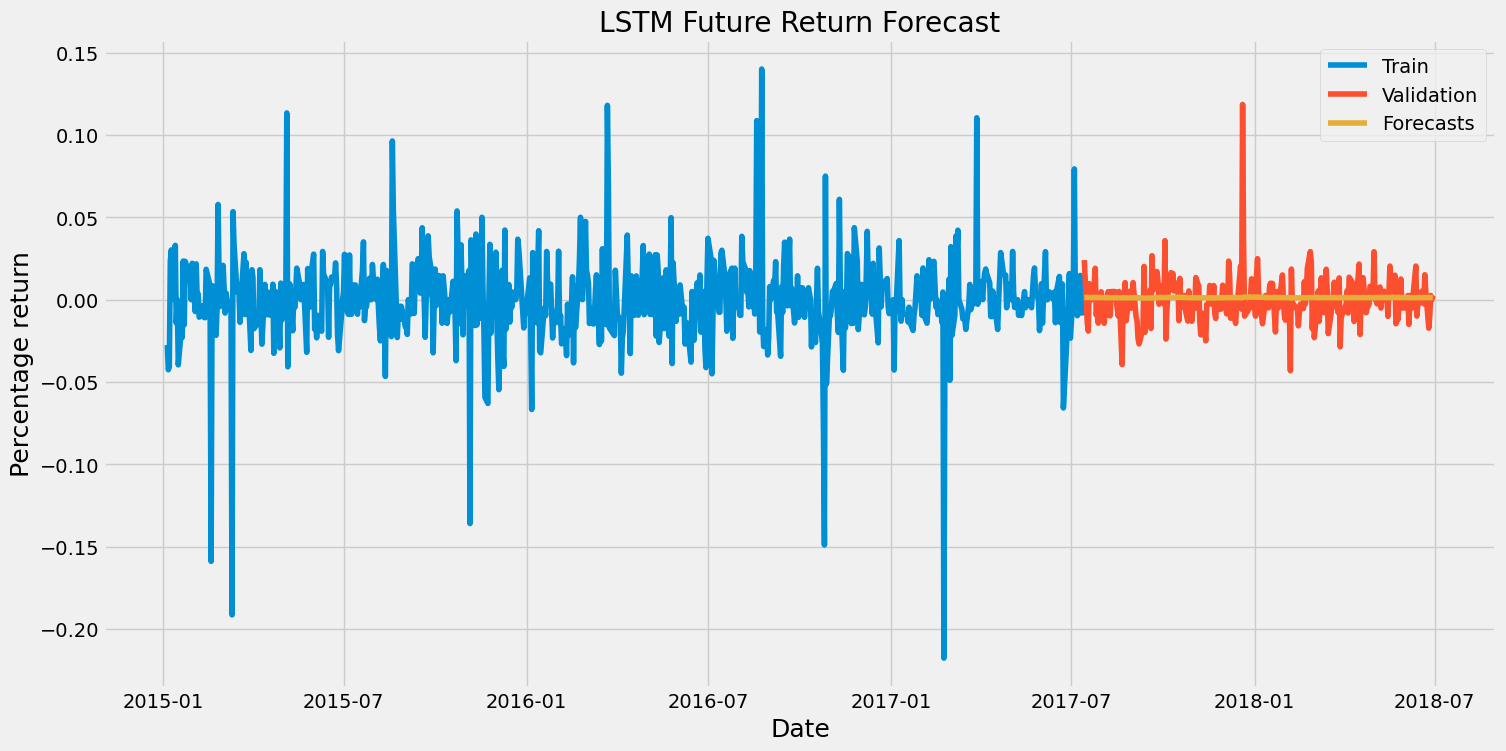

In [1122]:
#Plot Data
plt.figure(figsize=(16,8))
plt.title('LSTM Future Return Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Percentage return', fontsize=18)
plt.plot(train['FutureReturn1'])
plt.plot(valid[['FutureReturn1', 'forecasts']])
plt.legend(['Train', 'Validation', 'Forecasts'], loc='upper right')
plt.show()

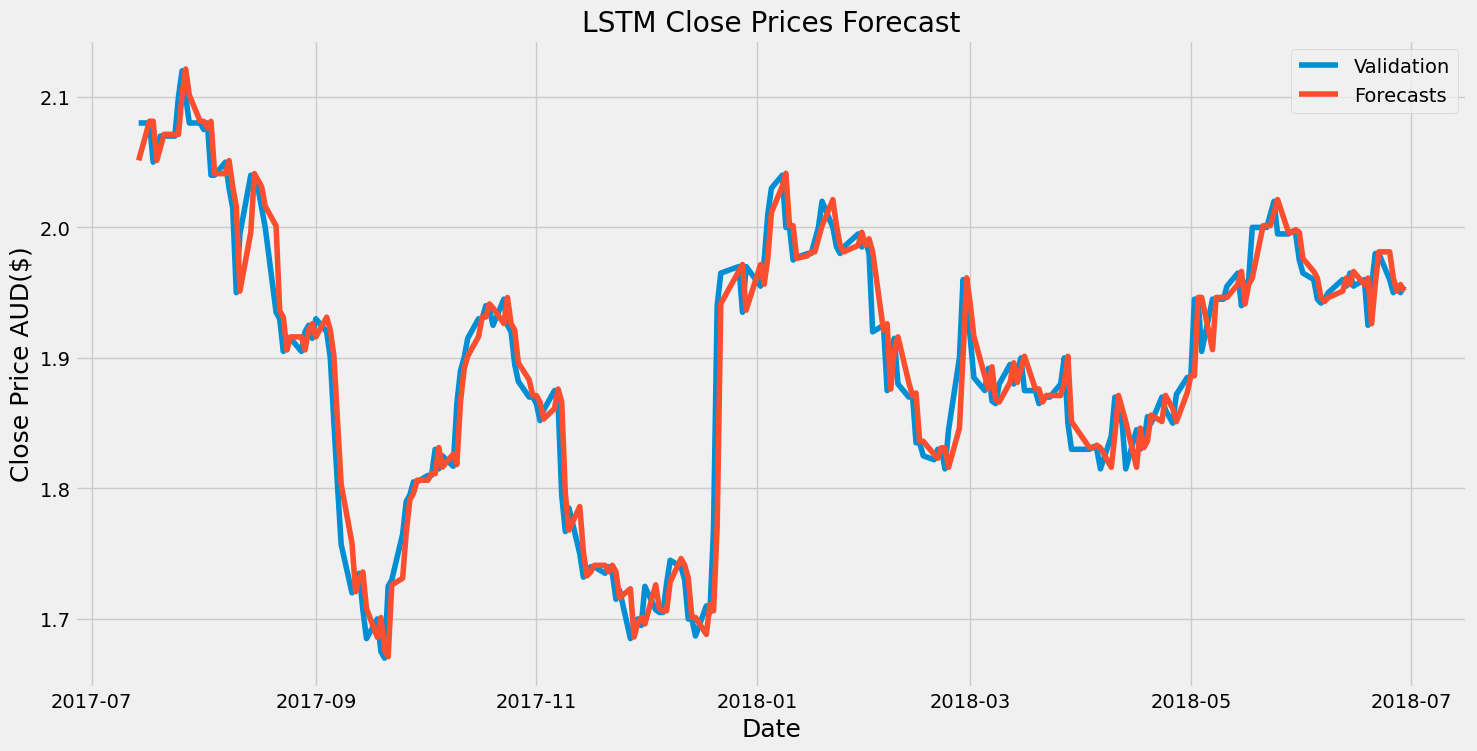

In [1123]:
#Plot Data
plt.figure(figsize=(16,8))
plt.title('LSTM Close Prices Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD($)', fontsize=18)
plt.plot(valid[['close', 'forecasts_close']])
plt.legend(['Validation', 'Forecasts'], loc='upper right')
plt.show()

From the graph above, we can see that the results are good as the model accurately predicts when prices are going to fall or rise. In other words, we have obtained a leading model.